# Problem Statement:Identify the loan eligibility process based on customer details

In [14]:
from warnings import filterwarnings
filterwarnings("ignore")
from scipy.stats import chi2_contingency
import pandas as pd
A = pd.read_csv("C:/Users/Audi/Downloads/Loan_training_set.csv")

In [15]:
A

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,NaN,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900.0,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106.0,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072.0,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583.0,0.0,187.0,360.0,1.0,Urban,Y


# Missing Data Treatment

In [16]:
A.isna().sum()

Loan_ID               0
Gender               15
Married               3
Dependents           15
Education             1
Self_Employed        32
ApplicantIncome       2
CoapplicantIncome     1
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [17]:
from preprocessing_6PM import replacer
replacer(A)

In [18]:
A.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# Define X and Y

In [19]:
Y = A[["Loan_Status"]]
X = A.drop(labels=["Loan_ID","Loan_Status"],axis=1) 

# Exploratory Data Analysis (EDA)

Y[cat] <---> X[con] --> ANOVA/boxplot
Y[cat] <---> X[cat] --> CHISQ/Countplot with Hue

In [20]:
imp_cols=[]
cat = []
con = []
for i in X.columns:
    if(X[i].dtypes == "object"):
        cat.append(i)
    else:
        con.append(i)

        
def ANOVA(df,cat,con):
    from pandas import DataFrame
    from statsmodels.api import OLS
    from statsmodels.formula.api import ols
    rel = con + " ~ " + cat
    model = ols(rel,df).fit()
    from statsmodels.stats.anova import anova_lm
    anova_results = anova_lm(model)
    Q = DataFrame(anova_results)
    a = Q['PR(>F)'][cat]
    return round(a,3)

def chisquare(df,cat1,cat2):
    import pandas as pd
    ct = pd.crosstab(df[cat1],df[cat2])
    a,b,c,d = chi2_contingency(ct)
    return b

# Find out the important column from continuous columns using ANOVA  

In [21]:
for i in con:
    q = ANOVA(A,"Loan_Status",i)
    print("-------------")
    print("Loan_Status vs",i)
    print("Pval: ",q)
    if(q < 0.15):
        imp_cols.append(i)

-------------
Loan_Status vs ApplicantIncome
Pval:  0.903
-------------
Loan_Status vs CoapplicantIncome
Pval:  0.142
-------------
Loan_Status vs LoanAmount
Pval:  0.368
-------------
Loan_Status vs Loan_Amount_Term
Pval:  0.604
-------------
Loan_Status vs Credit_History
Pval:  0.0


# Find out the important column from Catogarical  columns using chisquare

In [22]:
for i in cat:
    q = chisquare(A,"Loan_Status",i)
    print("-------------")
    print("Loan_Status vs",i)
    print("Pval: ",q)
    if(q < 0.15):
        imp_cols.append(i)

-------------
Loan_Status vs Gender
Pval:  0.7391461310869638
-------------
Loan_Status vs Married
Pval:  0.029608580862582116
-------------
Loan_Status vs Dependents
Pval:  0.3688663081366005
-------------
Loan_Status vs Education
Pval:  0.04309962129357355
-------------
Loan_Status vs Self_Employed
Pval:  1.0
-------------
Loan_Status vs Property_Area
Pval:  0.0021360187811644915


In [23]:
imp_cols

['CoapplicantIncome',
 'Credit_History',
 'Married',
 'Education',
 'Property_Area']

# Will check skew in important column and if its more will remove using log funcation

In [24]:
X.skew()

ApplicantIncome      6.538870
CoapplicantIncome    7.492000
LoanAmount           2.726601
Loan_Amount_Term    -2.389680
Credit_History      -1.963600
dtype: float64

In [25]:
from numpy import log

def skew_rem(df,col):
    q = []
    for i in df[col]:
        if(i != 0):
            q.append(log(i))
        else:
            q.append(i)
    df[col] = q

In [26]:
skew_rem(X,'ApplicantIncome')
skew_rem(X,'CoapplicantIncome')

In [27]:
X.skew()

ApplicantIncome      0.477562
CoapplicantIncome   -0.172920
LoanAmount           2.726601
Loan_Amount_Term    -2.389680
Credit_History      -1.963600
dtype: float64

# Data prepration in standard format for training the Model

In [29]:
from preprocessing_6PM import data_prep
Xnew = data_prep(X[imp_cols])

In [30]:
Xnew

,CoapplicantIncome,Credit_History,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,-1.107731,0.451640,1,0,1,0,0,0,1
1,0.782215,0.451640,0,1,1,0,1,0,0
2,-1.107731,0.451640,0,1,1,0,0,0,1
3,0.897656,0.451640,0,1,0,1,0,0,1
4,-1.107731,0.451640,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
609,-1.107731,0.451640,1,0,1,0,1,0,0
610,-1.107731,0.451640,0,1,1,0,1,0,0
611,0.307594,0.451640,0,1,1,0,0,0,1
612,-1.107731,0.451640,0,1,1,0,0,0,1


# Divide Data into training and testing set

In [31]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=21)

# Create a ML Model

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

model = lr.fit(xtrain,ytrain)

In [33]:
pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)

In [34]:
from sklearn.metrics import accuracy_score
tr_acc = accuracy_score(ytrain,pred_tr)
ts_acc = accuracy_score(ytest,pred_ts)
print("Training accuracy:",tr_acc)
print("Testing accuracy:",ts_acc)

Training accuracy: 0.8044806517311609
Testing accuracy: 0.8130081300813008


# Make predictions on testing set using this model model

In [37]:
B = pd.read_csv("C:/Users/Audi/Downloads/Loan_testing_set.csv")
B.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban


# Preprocessing on testing data set

In [38]:
X = B.drop(labels=["Loan_ID"],axis=1)
replacer(X)
Xnew = data_prep(X)
pred = model.predict(Xnew)

# Make predication if coustome is eligible or not 

In [41]:
B['Loan_Status_Pred']=pred
B.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status_Pred
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,Y
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,Y
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,Y
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban,Y
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,N


In [40]:
pd.DataFrame([Xnew.columns,dtc.feature_importances_]).T

,0,1
0,ApplicantIncome,0.243731
1,CoapplicantIncome,0.110746
2,LoanAmount,0.14866
3,Loan_Amount_Term,0.054186
4,Credit_History,0.30706
5,Gender_Female,0.01314
6,Gender_Male,0.0
7,Married_No,0.01316
8,Married_Yes,0.0
9,Dependents_0,0.004969


In [42]:
X = A[["Credit_History","LoanAmount","CoapplicantIncome"]]
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xnew = pd.DataFrame(ss.fit_transform(X),columns=["Credit_History","LoanAmount","CoapplicantIncome"])

In [43]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
model = km.fit(Xnew)
X['Cluster'] = model.labels_

In [44]:
q = []
for i in X.Credit_History:
    if(i < 0.5):
        q.append(0)
    else:
        q.append(1)

In [45]:
X.Credit_History = q

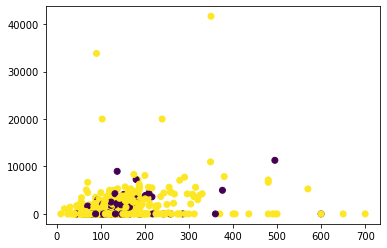

In [46]:
import matplotlib.pyplot as plt
plt.scatter(X.LoanAmount,X.CoapplicantIncome,c=q)

In [48]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
w = le.fit_transform(A['Loan_Status'])

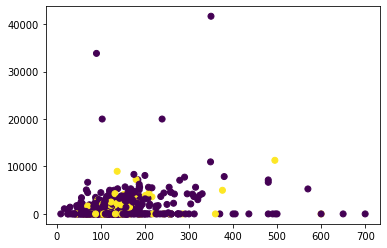

In [49]:
plt.scatter(X.LoanAmount,X.CoapplicantIncome,c=X.Cluster)

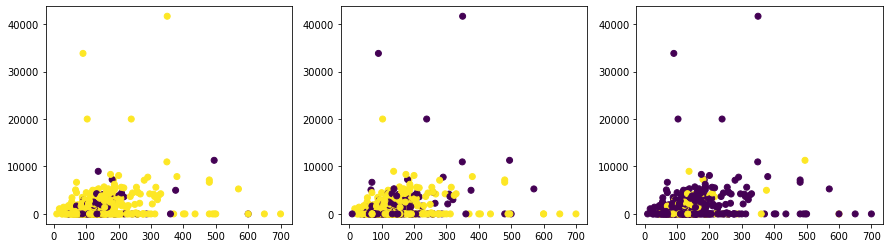

In [50]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(X.LoanAmount,X.CoapplicantIncome,c=q)
plt.subplot(1,3,2)
plt.scatter(X.LoanAmount,X.CoapplicantIncome,c=w)
plt.subplot(1,3,3)
plt.scatter(X.LoanAmount,X.CoapplicantIncome,c=X.Cluster)